## Assignment 7 - Iris dataset

In [60]:
from sklearn import datasets
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D



1) Describe the dataset

The dataset consists on 150 rows of data about plants that are classified in 3 classes (Setosa, Versicolour and Virginica). The features are Sepal Length and Width and Petal Length and Width. 

In [61]:
iris = datasets.load_iris()
#iris = pd.read_csv(
#    iris,
#    names=['Sepal length (cm)', 'Sepal width (cm)', 'Petal length (cm)', 'Petal width (cm)', 'Species']
#)

#### 2) Using pyMC3, we want to infer the parameters of the following models:
      a) The mean and standard deviation of the distribution of one feature chosen by you, that we assume as normally distributed.

In [247]:
#First I'mm geting the data


X1 = iris.data[:, :1]  # I take the first feature
myModel = pm.Model()
with myModel as model:
    obsMean = pm.Uniform("mean",lower=0,upper=10)
    obsSd = pm.HalfNormal("sd",sd=5)   
    exp = pm.Normal('exp', mu=obsMean, sd = obsSd, observed=X1)   
    trace = pm.sample(5000, step=pm.Metropolis())
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:05<00:00, 4148.41draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [235]:
pm.summary(trace)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,5.845,0.068,5.704,5.959,0.002,0.001,1402.0,1402.0,1398.0,1597.0,1.0
sd,0.835,0.048,0.749,0.929,0.001,0.001,1805.0,1805.0,1772.0,1829.0,1.0


b) The Petal Width as linear function of the other three features.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [sd]
>Metropolis: [mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:08<00:00, 2543.01draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128e9f550>,
      dtype=object)

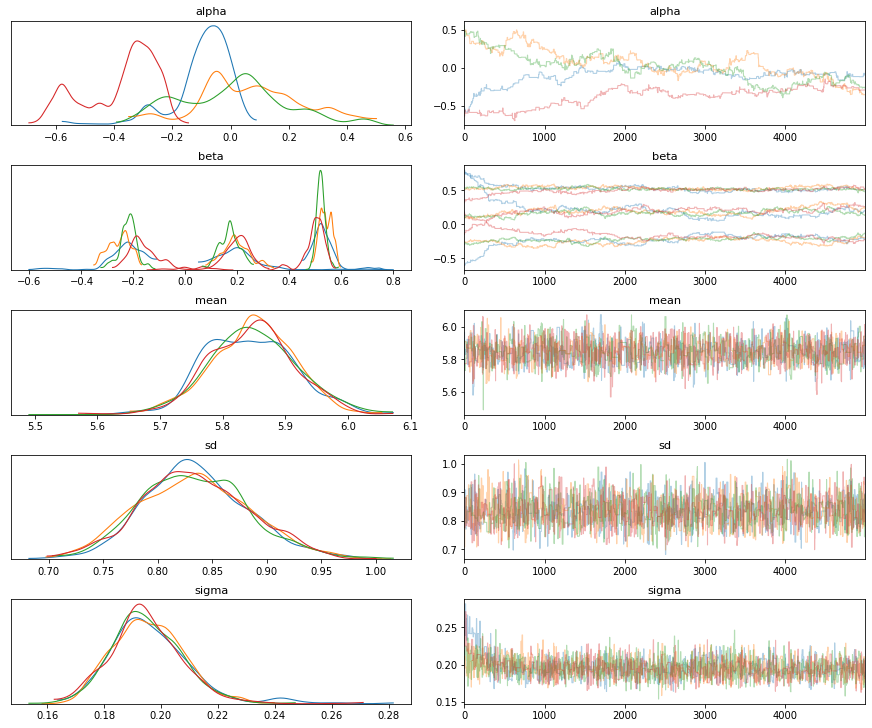

In [248]:
X2 = iris.data[:, 1:2]  # I take the first feature
X3 = iris.data[:, 2:3] 
X4 = iris.data[:, 3:4] 

with myModel as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=3)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2 + beta[2]*X3 #this is our expected ecuation

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=X4)
    

    trace = pm.sample(5000, step=pm.Metropolis())
pm.traceplot(trace)

In [249]:
map_estimate = pm.find_MAP(model=myModel)

map_estimate

logp = -164.57, ||grad|| = 0.14214: 100%|██████████| 52/52 [00:00<00:00, 1477.69it/s]  


{'mean_interval__': array(0.3405852),
 'sd_log__': array(-0.19209555),
 'alpha': array(-0.24030168),
 'beta': array([-0.20725908,  0.22281421,  0.52408106]),
 'sigma_log__': array(-1.66406904),
 'mean': array(5.84332669),
 'sd': array(0.82522801),
 'sigma': array(0.18936687)}

Petal width = -0.24 + (-0.207)*Sepal length + 0.222*Sepal width + 0.524*Petal length

3) Clusterize the plants according to its features and analyse the results of the clusters
as indication of the type of plant.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


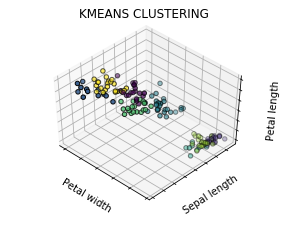

In [39]:

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_tags = ['Sepal length', 'Sepal width', 'Peatal length', 'Petal width']
estimator = KMeans(n_clusters=8)

fignum = 1
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
estimator.fit(X)
labels = estimator.labels_

ax.scatter(X[:, 3], X[:, 0], X[:, 2],
           c=labels.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('KMEANS CLUSTERING')
ax.dist = 12
fig.show()


4) Use a random forest classification and express which is the importance of each
feature to infer the type of plant.

In [44]:
clf = RandomForestClassifier(max_depth=2, oob_score=True)

for i in range(4):
    # I separate each feature and obtain the oob score for each one
    clf.fit(X[:,i].reshape(-1,1), y)
    print("Score using: " + feature_tags[i] + " " + str(clf.oob_score_))




Score using: Sepal length 0.7333333333333333
Score using: Sepal width 0.5866666666666667
Score using: Peatal length 0.9466666666666667
Score using: Petal width 0.9533333333333334


Seems clear ehat the best feature is Petal width, and the measures of Petals seems to be also better than the measures of Sepal.

5) Analyze the dependence (or independence) of each one of the features within the
data set.

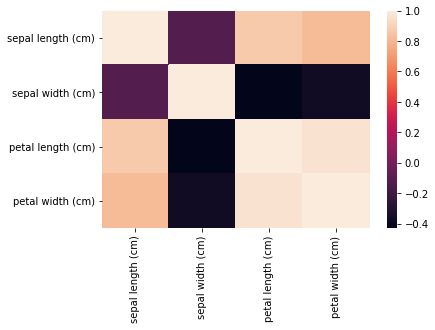

In [56]:
df = pd.DataFrame(iris.data, columns = iris.feature_names) 

corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


6) If we assign the following numerical values: Setosa=0, Versicolour=1, and Virginica=2 and we propose the following causal model:

Sepal Length -> Sepal Width -> Plant Type <- Petal Width <- Petal Length

a) Which relation of independence we should expect between Sepal Length and Petal Length? Check it.

b) And if we condition on Plant type? 

c) And if we condition on Petal Width?


In [72]:
matrix = [[0,1,0,0,0],[0,0,1,0,0],[0,0,0,0,0],[0,0,1,0,0],[0,0,0,1,0]]
def getPairIndeps(matrix):
    i=0
    j=0
    pairOfindep = list(list())
    #First I go for every item in the matrix and get every pair of independent nodes
    while i < len(matrix):
        while j < len(matrix):
            if matrix[i][j] == 0 and matrix[j][i] == 0 and i != j:
                pairOfindep.append([chr(ord('A')+i),chr(ord('A')+j)])
                #The chr(ord..) is to get an int from a char and viceversa.
            j+=1
        i+=1
        j=0


    index = int(len(pairOfindep)/2)    #I cut the list in half because of the repeated pairs.

    return pairOfindep[:index]

def haveParent(letter, matrix):
    parents = list()
    number = ord(letter) - ord('A')
    i=0
    while i < len(matrix):
        if(matrix[i][number] == 1):
            parents.append(chr(ord('A')+i))
        i+=1
    return list(set(parents))                #In order to avoid repeated parents. (Messy but it does work)
 
def getBasisSet(matrix):
    pairOfindep = getPairIndeps(matrix)
    basis_set = dict()
    
    for pair in pairOfindep:
        l = haveParent(pair[0],matrix) + haveParent(pair[1],matrix)
        basis_set[','.join(pair)] = l
    return basis_set
    
    


In [73]:
getBasisSet(matrix)

{'A,C': ['D', 'B'],
 'A,D': ['E'],
 'A,E': [],
 'B,D': ['A', 'E'],
 'B,E': ['A'],
 'C,A': ['D', 'B']}

In [195]:
import scipy.stats as st
def getIndependencies(basis_set, data, n):
    independencies = []
    for p in basis_set:
        pearson = st.pearsonr(data[ord(p[0]) - ord('A')], data[ord(p[2]) - ord('A')])[0]
        tr = (pearson*(n-2)**1/2) * ((1-pearson**2)**1/2)
        pval = st.t.sf(np.abs(tr), n-1)*2  
        print(pval)
        independencies.append([p[0],p[2],pval <= 0.05])
    
    return independencies



In [174]:
y = iris.target
Y = [[int(y)] for y in y]

In [180]:
X = np.array(X, dtype= object)
X = np.append(X,Y,axis=1)


In [196]:
getIndependencies(getBasisSet(matrix), X, 200)

0.9984422150300938
0.8898241607311913
0.9670940633711577
0.8499724643942669
0.6348591352858539
0.9984422150300938


[['A', 'C', False],
 ['A', 'D', False],
 ['A', 'E', False],
 ['B', 'D', False],
 ['B', 'E', False],
 ['C', 'A', False]]

Even if i obtained that all options are dependant, I think that between Sepal Length (A) and Petal Length (E) there should be independence, so I have something wrong in my code but I can't figure out what it is.

If we condition on Plant Type, the vertex is now active so there would be dependence. And if we condition on PEtal Width we inactive that vertex so the relationship should be independent. 